In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
nltk.download('stopwords')
nltk.download('wordnet')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# word cloud text visualization
from wordcloud import WordCloud, STOPWORDS
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer


## Data Description
The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

### File descriptions
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format
### Data fields
- id - a unique identifier for each sentence
- text - some text written by one of the authors
- author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)


## Exploratory Data Analysis

In [0]:
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [0]:
data.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id14225,The gentle manners and beauty of the cottagers...,EAP
freq,1,1,7900


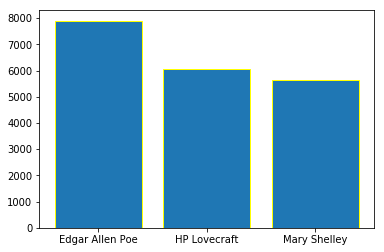

In [0]:
def plot_count():
  """
  This functin retun a bar plot for each author count appear in train set 
  """
  z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
  
  # mapping authro short name to full name
  x = data.author.map(z).unique()
  
  # getting count for each author text appear in train dataset
  y = data.author.value_counts().values
  
  plt.bar(x,y, edgecolor='yellow')
  plt.show()
  
  
plot_count()

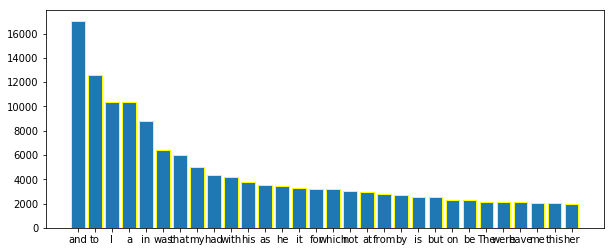

In [0]:
def plot_words_count():
  """
  This function will return a bar plot for first 30 words counts appears in dataset
  """
  # getting all words and their count of occurances
  words = data.text.str.split(expand=True).unstack().value_counts()
  
  # selecting 30 words
  x = words.index.values[2:32]
  y = words.values[2:32]
  
  # plotting barplot
  fig = plt.figure()
  fig.set_figwidth(10)
  plt.bar(x,y, edgecolor = 'yellow')
  
plot_words_count()

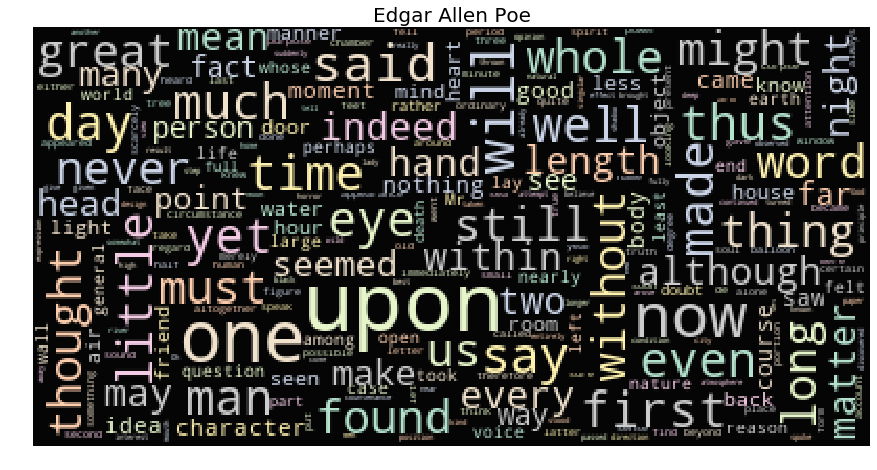

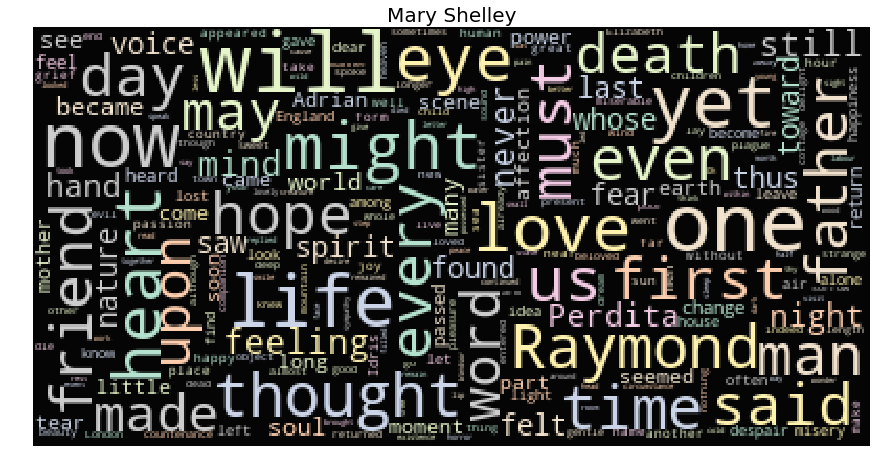

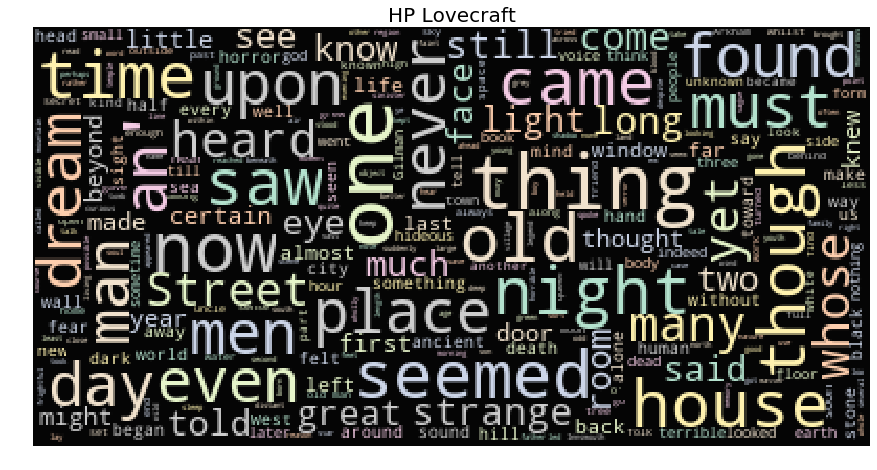

In [0]:
def word_cloud_viz():
  """
  This function will return word_cloud visualization of words for each author text
  """
  # python list that store text of three author
  eap = data[data.author=="EAP"]["text"].values
  hpl = data[data.author=="HPL"]["text"].values
  mws = data[data.author=="MWS"]["text"].values
  # z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}

  # plotting Edgar Allen Poe word_cloud
  plt.figure(figsize=(15, 10))
  wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size=40)
  wc.generate(" ".join(eap))
  plt.title("Edgar Allen Poe", fontsize=20)
  plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
  plt.axis('off')

  
  # plotting Edgar Allen Poe word_cloud
  plt.figure(figsize=(15, 10))
  wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size=40)
  wc.generate(" ".join(mws))
  plt.title("Mary Shelley", fontsize=20)
  plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
  plt.axis('off')
  
  
  # plotting Edgar Allen Poe word_cloud
  plt.figure(figsize=(15, 10))
  wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size=40)
  wc.generate(" ".join(hpl))
  plt.title("HP Lovecraft", fontsize=20)
  plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
  plt.axis('off')
  
  
word_cloud_viz()

In [0]:
# invoking lemmatizer from nltk
# here we are customizing sklearn count vectorizer class. We are including lemmalizer along with it
# so that our preprocessin can be done with one place

lemma = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
  def build_analyzer(self):
    analyzer = super(LemmaCountVectorizer, self).build_analyzer()
    return lambda doc: (lemma.lemmatize(w) for w in analyzer(doc))

In [0]:
# level encoding of our target variables
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(data.author.values)

In [0]:
# train test spliting
x_train, x_test, y_train, y_test = train_test_split(data.text.values, y,
                                                    stratify=y,
                                                    random_state=42,
                                                    test_size=0.1,
                                                    shuffle=True)

In [0]:
# vectorizing along with preprocessing
tf_vectorizer = LemmaCountVectorizer(min_df=3,
                                     max_features=None, 
                                     strip_accents='unicode',
                                     analyzer='word',token_pattern=r'\w{1,}',
                                     ngram_range=(1, 3),
                                     #use_idf=1,
                                     #smooth_idf=1,
                                     #sublinear_tf=1,
                                     stop_words = 'english')

tf_vectorizer.fit(list(x_train) + list(x_test))
tf_train = tf_vectorizer.transform(x_train)
tf_test = tf_vectorizer.transform(x_test)

In [0]:
all_score = dict()

In [0]:
# first model -> logistic regression model
classifier = LogisticRegression(C=1.0)

# fitting data into model
classifier.fit(tf_train, y_train)

# evaluating score
score = classifier.score(tf_test, y_test)

# storing score in dictionary
all_score['logistic regression'] =  score

# printing score
print("Score of Logistic Regression: ", score)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Score of Logistic Regression:  0.806435137895812


In [0]:
# Naive Bayes Classifier
NBclassifier = MultinomialNB()

# fitting data into model
NBclassifier.fit(tf_train, y_train)

# evaluating score
score = NBclassifier.score(tf_test, y_test)

# storing score in dictionary
all_score['Naive Bayes'] =  score

# printing score
print("Score of Naive Bayes Model: ", score)

Score of Naive Bayes Model:  0.8253319713993871


In [0]:
# Naive Bayes Classifier
NBclassifier = MultinomialNB()

# fitting data into model
NBclassifier.fit(tf_train, y_train)

# evaluating score
score = NBclassifier.score(tf_test, y_test)

# storing score in dictionary
all_score['Naive Bayes'] =  score

# printing score
print("Score of Naive Bayes Model: ", score)

In [0]:
# XGBoost Classifier
XGBclassifier = xgb.XGBClassifier(max_depth=7,
                                  n_estimators=200,
                                  colsample_bytree=0.8,
                                  subsample=0.8,
                                  nthread=10,
                                  learning_rate=0.1)

# fitting data into model
XGBclassifier.fit(tf_train, y_train)

# evaluating score
score = XGBclassifier.score(tf_test, y_test)

# storing score in dictionary
all_score['XGBoost'] =  score

# printing score
print("Score of Naive Bayes Model: ", score)

Score of Naive Bayes Model:  0.6772216547497446


In [0]:
# Performance Comparison



## Performance Comparison

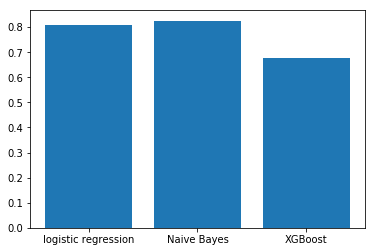

In [0]:
def show_com():
  model_name = [model for model in all_score.keys()]
  score = [score for score in all_score.values()]
  
  plt.bar(model_name, score)
  plt.show()
  

show_com()